In [400]:
import xarray as xr
import numpy as np
import geopandas
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib import cm

import cartopy.crs as ccrs
import cartopy.feature as cf

# Plotting parameters

In [378]:
fontsize = 7
coastlines_lw = 0.5
linewidth = 1.1
patheffect_lw_add = linewidth * 1.8
    
plt_params = {'lines.linewidth': linewidth,
              
              'hatch.linewidth': 0.5,
    
              'font.size': fontsize,
              
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.7,
              'legend.labelspacing' : 0.03,
              'legend.handlelength' : 1.,
             
              'axes.linewidth': 0.5}

# Load ERA-NUTS data

In [615]:
data_dir = '../data/'

### Region shape files

In [616]:
# Must be the '4326' version for lat/lon coords
f = 'ref-nuts-2016-01m.shp/NUTS_RG_01M_2016_4326_LEVL_0.shp/NUTS_RG_01M_2016_4326_LEVL_0.shp'

In [617]:
nuts_regions = geopandas.read_file(data_dir + f)

In [618]:
def process_data(fp):
    """Read in csv data and convert to xarray object"""
    df = pd.read_csv(data_dir + fp, index_col=0, parse_dates=True)
    return xr.DataArray(df,
                        dims=['time', 'region'],
                        coords={'time': df.index, 'region': df.columns})

In [619]:
def resample_ds(ds, window, target_month=None, time_dim='time'):
    """Resample data to x-monthly and select a particular month if desired"""
    ds_m = ds.resample({time_dim: 'MS'}).mean()
    ds_r = ds_m.rolling({time_dim: window}).mean()
    if target_month:
        ds_r =  ds_r.isel({time_dim: ds_r.groupby('time.month').groups[target_month]})
    return ds_r

In [620]:
def get_ranks(da, year):
    if len(da.dims) == 1:
        regions = list([da.region.values.item()])
        ranks = {regions[0]: 0}
        print(regions)
    else:
        regions = da.region.values
        ranks = {r: 0 for r in regions}
    for r in regions:
        x = da.sel(region=r).to_dataset(name='x').sortby('x')
        ranks[r] = np.where(x.time.dt.year == year)[0][0] + 1
    return ranks

### Europe 100m wind speed

In [621]:
ws_n0 = process_data('era-nuts-ws100-nuts0-daily-singleindex.csv')

In [622]:
ws_n0_jas = resample_ds(ws_n0, window=5, target_month=9)

In [623]:
ws_2021_ranks = get_ranks(ws_n0_2021_jas, 2021)

In [624]:
# Restructure shapefile dataframe and add wind speed rank
nuts_regions = nuts_regions.set_index('CNTR_CODE').loc[ws_2021_ranks.keys()]
nuts_regions['ws100'] = ws_2021_ranks.values()

### Scotland 100m wind speed and runoff - May through September 2021

#### Wind speed

In [625]:
ws_n1 = process_data('era-nuts-ws100-nuts1-daily-singleindex.csv')

In [626]:
ws_sc = ws_n1.sel(region='UKM')

In [627]:
ws_sc_mjjas = resample_ds(ws_sc, window=5, target_month=9)

#### Runoff

In [628]:
ro_n1 = process_data('era-nuts-ro-nuts1-daily-singleindex.csv')

In [629]:
ro_sc = ro_n1.sel(region='UKM').expand_dims({'region': ['UKM']}) # units are mm/hour

#### Unrealistic values in 2020:

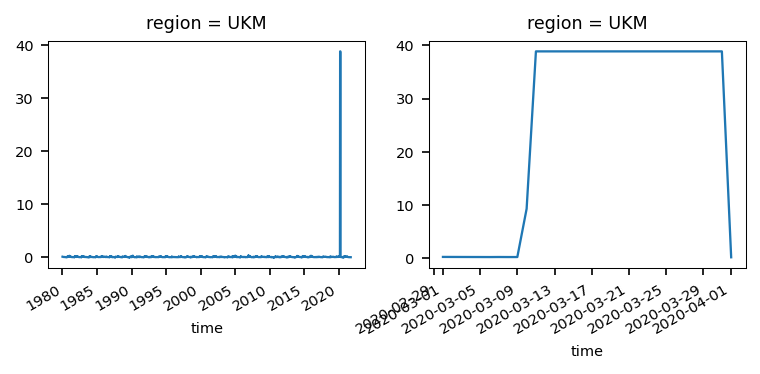

In [630]:
with mpl.rc_context(plt_params):
    fig, ax = plt.subplots(1, 2, figsize=(6,2), dpi=150)
    ro_sc.plot(ax=ax[0])
    ro_sc.sel(time=slice('2020-03', '2020-04-01')).plot(ax=ax[1])

#### Set March 2020 to NaN

In [631]:
ro_sc = ro_sc.where(~((ro_sc.time.dt.year == 2020) & (ro_sc.time.dt.month == 3)))

In [632]:
ro_sc_mjjas = resample_ds(ro_sc, window=5, target_month=9)

## Plot

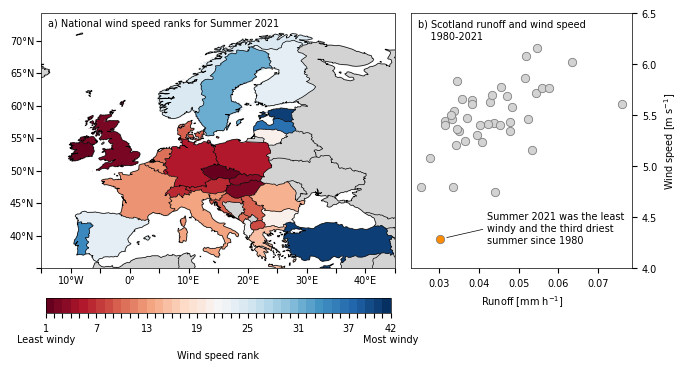

In [633]:
with mpl.rc_context(plt_params):
    
    #======== Set up subplots
    fig = plt.figure(figsize=(6.9, 3), dpi=100)

    gs1 = fig.add_gridspec(nrows=1, ncols=1,
                          left=0.05, right=0.65,
                          bottom=0.1, top=0.95)
    gs2 = fig.add_gridspec(nrows=1, ncols=1,
                          left=0.63, right=0.95,
                          bottom=0.10, top=0.95)

    # ======= Europe wind speeds
    ax1 = plt.subplot(gs1[0], projection=ccrs.PlateCarree())
    ax1.set_extent([-15, 45, 72, 35])
    ax1.coastlines(lw=0.5)
    ax1.add_feature(cf.BORDERS, lw=0.5)
    ax1.add_feature(cf.LAND, color='lightgray')    
    
    # Discretise colorbar
    bounds = np.arange(1, 43, 1)
    cmap = cm.get_cmap('RdBu')
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    p = nuts_regions.plot(ax=ax1, column='ws100', cmap=cmap, norm=norm,
                          vmin=1, vmax=42)
    
    # add colorbar - had to hack using https://stackoverflow.com/questions/36008648/colorbar-on-geopandas
    fig2 = ax1.get_figure()
    cax = fig2.add_axes([0.1, -0.05, 0.5, 0.05])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)#plt.Normalize(vmin=1, vmax=42))
    sm._A = []
    cb1 = fig2.colorbar(sm, cax=cax, orientation='horizontal', ticks=range(1,43))
    cb1.ax.set_xlabel('Wind speed rank')
    cbar_tick_labels = []
    for i in range(1,43,6):
        cbar_tick_labels.append(i)
        for j in range(5):
            cbar_tick_labels.append('')
    cbar_tick_labels = cbar_tick_labels[:42]
    cbar_tick_labels[0] = '1\nLeast windy'
    cbar_tick_labels[-1] = '42\nMost windy'
    cb1.ax.set_xticklabels(cbar_tick_labels)
    
    ax1.set_xticks(np.arange(-15, 50, 5))
    ax1.set_yticks(np.arange(35, 75, 5))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
    gl_labels = ax1.gridlines(crs=ccrs.PlateCarree(),
                             draw_labels=True,
                             linewidth=0, 
                             color='grey', 
                             linestyle='-',
                             xlocs=np.arange(-20, 50, 10),
                             ylocs=np.arange(35, 80, 5))
    gl_labels.top_labels = False
    gl_labels.right_labels = False
    gl_labels.xlabel_style = {'fontsize': plt_params['font.size']}
    gl_labels.ylabel_style = {'fontsize': plt_params['font.size']}
    
    ax1.text(0.02, 0.95, 'a) National wind speed ranks for Summer 2021',
            transform=ax1.transAxes)
    
    #======== Scotland runoff and wind speed
    ax2 = plt.subplot(gs2[0])
    ax2.scatter(ro_sc_mjjas[0].values[:-1], ws_sc_mjjas[:-1], color='lightgray', ec='gray', lw=0.6)
    ax2.scatter(ro_sc_mjjas.values[0,-1], ws_sc_mjjas[-1], color='darkorange', ec='gray', lw=0.6)
    
    ax2.set_xticks(np.arange(0.02, 0.09, 0.01))
    ax2.set_xlabel(r'Runoff [mm h$^{-1}$]')

    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylim(4, 6.5)
    ax2.set_yticks(np.arange(4, 6.6, 0.5))
    ax2.set_ylabel(r'Wind speed [m s$^{-1}$]')
    
    ax2.text(0.03, 0.9, 'b) Scotland runoff and wind speed\n    1980-2021',
            transform=ax2.transAxes)
    ax2.text(0.042, 4.25, 'Summer 2021 was the least\nwindy and the third driest\nsummer since 1980')
    ax2.plot((0.032, 0.041), (4.3, 4.38), color='k', lw=0.5)
    
    plt.savefig('./figures/summer_2021.pdf', bbox_inches='tight', format='pdf', dpi=400)